## Humidity Prediction with Time-Series using LSTM Models

### Introduction
Humidity prediction using time-series data and deep learning models has become increasingly relevant in various domains such as agriculture, HVAC systems, and environmental monitoring. Accurate humidity prediction can provide valuable insights for optimizing operations, improving efficiency, and ensuring the well-being of occupants in indoor environments. In this project, we leverage deep learning techniques, specifically Long Short-Term Memory (LSTM) networks, to predict humidity levels based on historical sensor data. The dataset comprises multivariate time-series data, including temperature, TVOC (Total Volatile Organic Compounds), eCO2 (equivalent Carbon Dioxide), and other environmental variables.

This project aims to develop and evaluate different LSTM-based models for humidity prediction, comparing their performance and identifying the most effective approach. We explore three types of LSTM architectures: vanilla LSTM, stacked LSTM, and bidirectional LSTM, each tailored to capture temporal dependencies and patterns in the data effectively. Through this project, we aim to demonstrate the feasibility and effectiveness of deep learning models for humidity prediction tasks, showcasing their potential for real-world applications in diverse industries where accurate environmental monitoring is critical. By accurately forecasting humidity levels, stakeholders can make informed decisions, mitigate risks, and optimize resource utilization, ultimately leading to improved operational outcomes and enhanced user comfort.

### Load Required Python Library

In [29]:
import keras
import pandas as pd
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')
# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from IPython.display import display, HTML
from keras.callbacks import EarlyStopping
from keras.models import Sequential,load_model
from keras.layers import InputLayer, LSTM, Dense, Dropout, BatchNormalization
from keras.layers import Bidirectional, Flatten

from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam
import pickle
from sklearn.preprocessing import MinMaxScaler

### Read And Analyze Data

In [30]:
# Load your data from the pickle file
with open("/kaggle/input/smoke-detection-iot-clearned/smoke_detection_iot_cleaned.pkl", "rb") as f:
    df = pickle.load(f)

# Display the first few rows of the dataframe
df.head()


,Temperature[C],Humidity[%],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,DateTime
0,20.000,57.36,0,400,12306,18520,939.735,0.0,0.0,0.0,0.0,0.0,0,2022-06-09 00:08:51
1,20.015,56.67,0,400,12345,18651,939.744,0.0,0.0,0.0,0.0,0.0,0,2022-06-09 00:08:52
2,20.029,55.96,0,400,12374,18764,939.738,0.0,0.0,0.0,0.0,0.0,0,2022-06-09 00:08:53
3,20.044,55.28,0,400,12390,18849,939.736,0.0,0.0,0.0,0.0,0.0,0,2022-06-09 00:08:54
4,20.059,54.69,0,400,12403,18921,939.744,0.0,0.0,0.0,0.0,0.0,0,2022-06-09 00:08:55


In [31]:
# Sort the DataFrame based on the 'UTC' column in ascending order
df = df.sort_values(by='DateTime')

In [32]:
df.shape

(62630, 14)

In [33]:
# Reduce data by every 5th second
df = df[::5]

In [34]:
# Switch Humidity and Temperature indexes
df = df.iloc[:,[1,0,2,3,4,5,6,7,8,9,10,11,12,13]]
df.head()

,Humidity[%],Temperature[C],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm,DateTime
51142,43.27,27.45,48,488,12844,20723,937.586,2.04,2.12,14.05,2.191,0.049,0,2022-06-08 18:16:27
51147,44.09,27.22,19,449,12862,20754,937.583,2.29,2.38,15.78,2.460,0.056,0,2022-06-08 18:16:32
51152,44.40,27.11,30,459,12853,20752,937.571,2.42,2.51,16.64,2.595,0.059,0,2022-06-08 18:16:37
51157,44.65,27.01,13,435,12870,20766,937.572,2.25,2.33,15.46,2.411,0.054,0,2022-06-08 18:16:42
51162,44.83,26.92,15,431,12861,20767,937.599,1.96,2.03,13.48,2.102,0.047,0,2022-06-08 18:16:47


In [35]:
df.shape

(12526, 14)

### Convert 'DateTime' column to datetime type and set it as the index

In [36]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df.set_index('DateTime', inplace=True)

In [37]:
df.head()

,Humidity[%],Temperature[C],TVOC[ppb],eCO2[ppm],Raw H2,Raw Ethanol,Pressure[hPa],PM1.0,PM2.5,NC0.5,NC1.0,NC2.5,Fire Alarm
DateTime,,,,,,,,,,,,,
2022-06-08 18:16:27,43.27,27.45,48,488,12844,20723,937.586,2.04,2.12,14.05,2.191,0.049,0
2022-06-08 18:16:32,44.09,27.22,19,449,12862,20754,937.583,2.29,2.38,15.78,2.460,0.056,0
2022-06-08 18:16:37,44.40,27.11,30,459,12853,20752,937.571,2.42,2.51,16.64,2.595,0.059,0
2022-06-08 18:16:42,44.65,27.01,13,435,12870,20766,937.572,2.25,2.33,15.46,2.411,0.054,0
2022-06-08 18:16:47,44.83,26.92,15,431,12861,20767,937.599,1.96,2.03,13.48,2.102,0.047,0


## Train and evaluate different models

### Create Model Helping Functions

In [43]:
def df_to_X_y(df_as_np, window_size=6):
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)


def create_vanilla_lstm_model(seq_length, nb_features, nb_out=1):
    model = Sequential()
    model.add(LSTM(units=512, input_shape=(seq_length, nb_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=nb_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mse'])
    model.summary()
    return model

def create_stacked_lstm_model(seq_length, nb_features, nb_out=1):
    model = Sequential()
    model.add(LSTM(units=512, input_shape=(seq_length, nb_features), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=512, return_sequences=False))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=nb_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mse'])
    model.summary()
    return model

def create_bidirectional_lstm_model(seq_length, nb_features, nb_out=1):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=512, return_sequences=True), input_shape=(seq_length, nb_features)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(units=512, return_sequences=False)))
    model.add(Dropout(0.3))
    model.add(BatchNormalization())
    model.add(Dense(units=512, activation='relu'))
    model.add(Dense(units=nb_out, activation='linear'))
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mse'])
    model.summary()
    return model


def train_model(model, X_train, y_train, X_test,y_test, model_path = 'LSTM_model1.h5'):
    history = model.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 100,
                       verbose=2,
              callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                       min_delta=0,
                                                       patience=10,
                                                       verbose=0,
                                                       mode='min'),
                         keras.callbacks.ModelCheckpoint(model_path,
                                                 monitor='val_loss',
                                                 save_best_only=True,
                                                 mode='min',
                                                 verbose=0)
                                    ])
    model.save(model_path)
    # list all data in history
    print(history.history.keys())
    return history


def view_history_mse_loss(history, png_name='.png'):
    # summarize history for MSE
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mse'])
    plt.plot(history.history['val_mse'])
    plt.title('model mse')
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_acc.savefig("mse" + png_name)

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    fig_acc.savefig("loss" + png_name)

### Create feature selected subset and split the data into train and test sets

In [39]:
df_selected = df[['Humidity[%]', 'Temperature[C]', 'TVOC[ppb]', 'eCO2[ppm]', 'Raw H2',
       'Pressure[hPa]', 'PM1.0', 'Fire Alarm']]

# split data subset 80/20 for train/validation
split_point = round(len(df)*0.8)
df_train = df.iloc[:split_point]
df_val = df.iloc[split_point:]

split_point = round(len(df_selected)*0.8)
df_selected_train = df_selected.iloc[:split_point]
df_selected_val = df_selected.iloc[split_point:]

### Normalize Data

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))
df_train_scaled = scaler.fit_transform(df_train)
df_val_scaled = scaler.transform(df_val)

df_selected_train_scaled = scaler.fit_transform(df_selected_train)
df_selected_val_scaled = scaler.transform(df_selected_val)

In [41]:
X_train, y_train = df_to_X_y(df_train_scaled, 30)
X_val, y_val = df_to_X_y(df_val_scaled, 30)

X_selected_train, y_train = df_to_X_y(df_selected_train_scaled, 30)
X_selected_val, y_val = df_to_X_y(df_selected_val_scaled, 30)

In [42]:
print("X_val Shape-- ",X_val.shape)
print("y_val Shape-- ",y_val.shape)
seq_length = X_val.shape[1]
nb_features = X_val.shape[2]
print("X_selected_val Shape-- ",X_selected_val.shape)
print("y_val Shape-- ",y_val.shape)
seq_selected_length = X_selected_val.shape[1]
nb_selected_features = X_selected_val.shape[2]

X_val Shape--  (2475, 30, 13)
y_val Shape--  (2475,)
X_selected_val Shape--  (2475, 30, 8)
y_val Shape--  (2475,)


## Model Selection

### Train and View the history of models without Feature Selection

In [44]:
vanilla_lstm_model = create_vanilla_lstm_model(seq_length, nb_features, nb_out=1)
stacked_lstm_model = create_stacked_lstm_model(seq_length, nb_features, nb_out=1)
bidirectional_lstm_model = create_bidirectional_lstm_model(seq_length, nb_features, nb_out=1)
models = {"vanilla_lstm_model": vanilla_lstm_model, 
          "stacked_lstm_model": stacked_lstm_model, 
          "bidirectional_lstm_model": bidirectional_lstm_model}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 512)           1077248   
                                                                 
 dropout (Dropout)           (None, 30, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                        

In [45]:
histories = {}
for k in models:
    history = train_model(models[k], X_train, y_train, X_val, y_val, 
                          model_path = k + '.h5')
    histories[k] = history


Epoch 1/100


I0000 00:00:1708875863.523418     685 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


313/313 - 11s - loss: 0.1239 - mse: 0.1239 - val_loss: 0.0833 - val_mse: 0.0833 - 11s/epoch - 35ms/step
Epoch 2/100
313/313 - 3s - loss: 0.0323 - mse: 0.0323 - val_loss: 0.1448 - val_mse: 0.1448 - 3s/epoch - 9ms/step
Epoch 3/100
313/313 - 3s - loss: 0.0172 - mse: 0.0172 - val_loss: 0.1615 - val_mse: 0.1615 - 3s/epoch - 9ms/step
Epoch 4/100
313/313 - 3s - loss: 0.0108 - mse: 0.0108 - val_loss: 0.1544 - val_mse: 0.1544 - 3s/epoch - 9ms/step
Epoch 5/100
313/313 - 3s - loss: 0.0087 - mse: 0.0087 - val_loss: 0.1422 - val_mse: 0.1422 - 3s/epoch - 9ms/step
Epoch 6/100
313/313 - 3s - loss: 0.0074 - mse: 0.0074 - val_loss: 0.1069 - val_mse: 0.1069 - 3s/epoch - 9ms/step
Epoch 7/100
313/313 - 3s - loss: 0.0085 - mse: 0.0085 - val_loss: 0.1177 - val_mse: 0.1177 - 3s/epoch - 9ms/step
Epoch 8/100
313/313 - 3s - loss: 0.0070 - mse: 0.0070 - val_loss: 0.1075 - val_mse: 0.1075 - 3s/epoch - 9ms/step
Epoch 9/100
313/313 - 3s - loss: 0.0065 - mse: 0.0065 - val_loss: 0.1674 - val_mse: 0.1674 - 3s/epoch - 9

vanilla_lstm_model


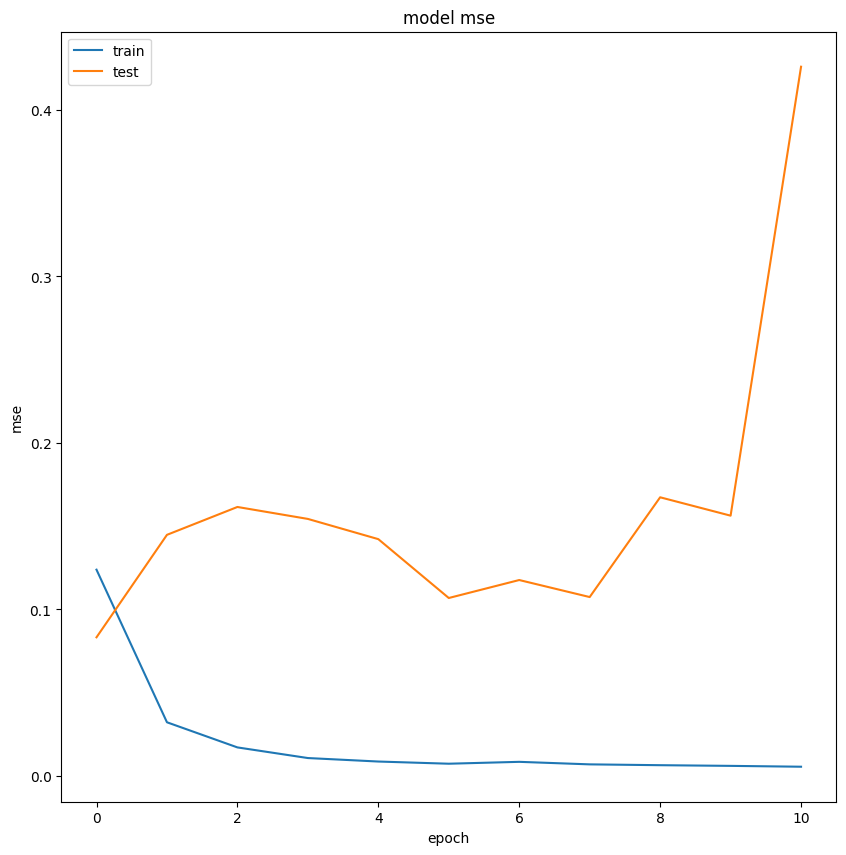

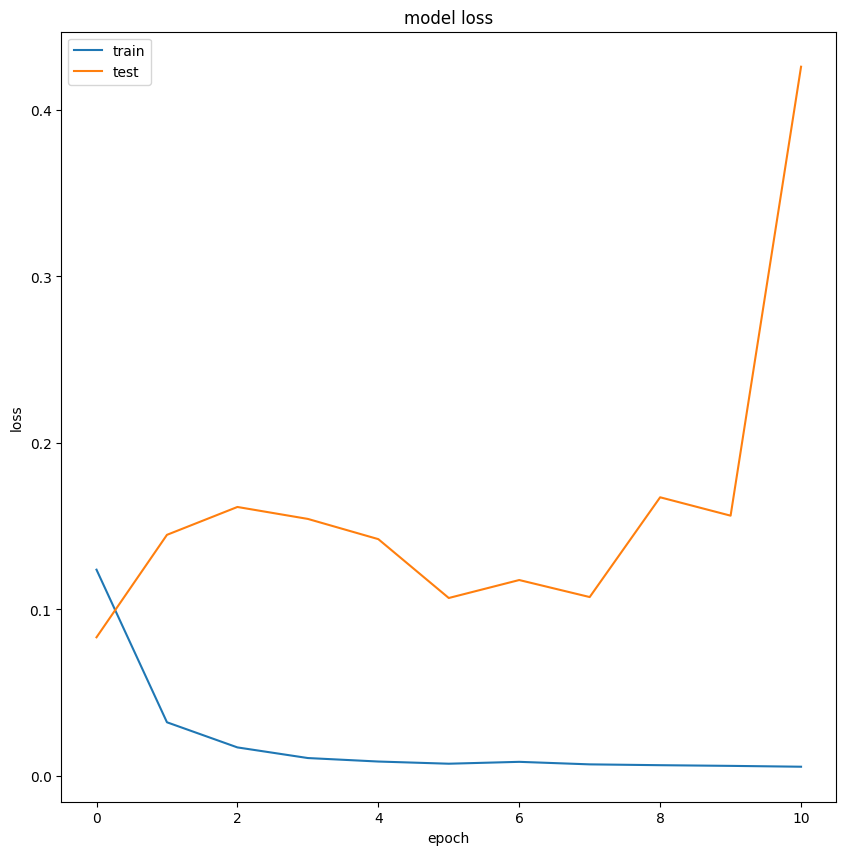

stacked_lstm_model


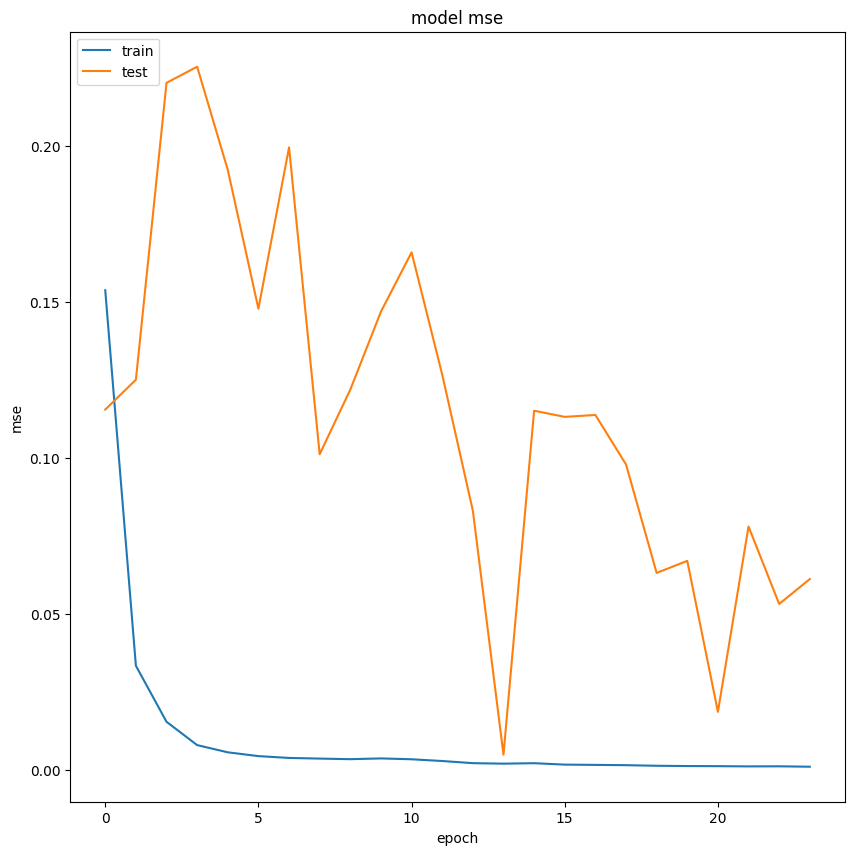

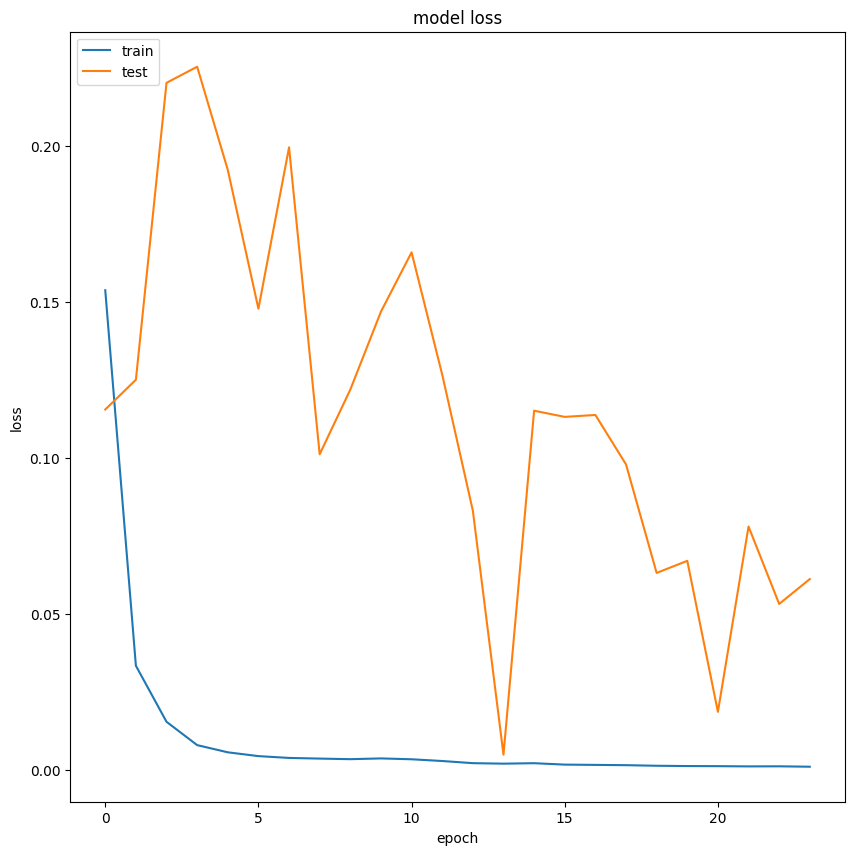

bidirectional_lstm_model


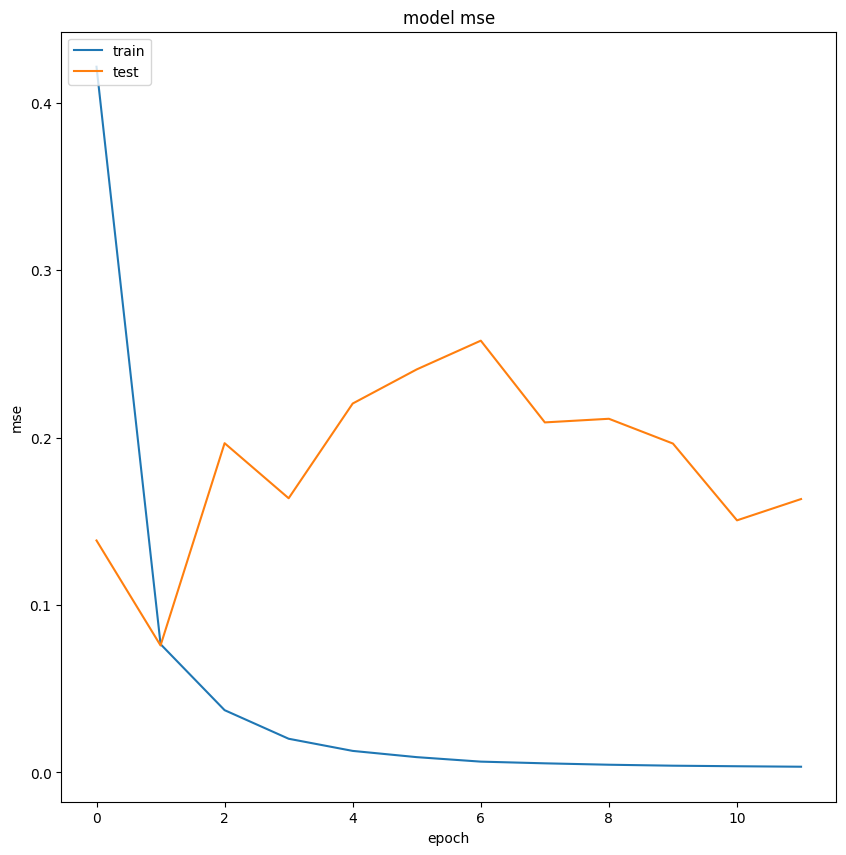

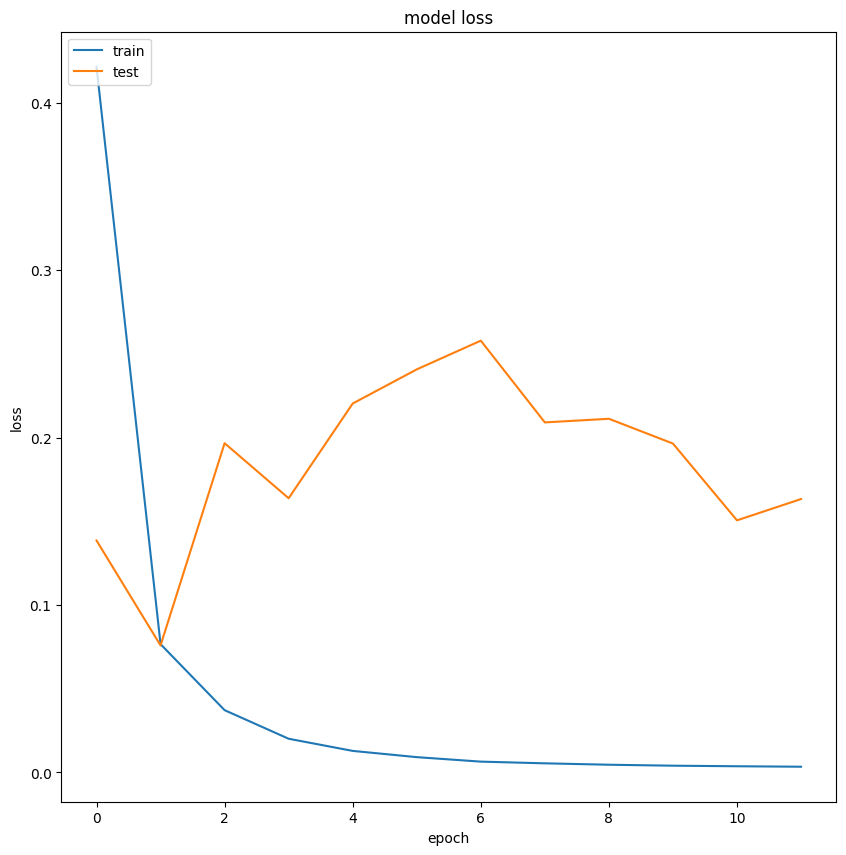

In [46]:
for k in histories:
    print(f"{k}")
    view_history_mse_loss(histories[k], k + '.png')

### Train and View the history of models with Feature Selection

In [47]:
vanilla_lstm_model_selected = create_vanilla_lstm_model(seq_selected_length, nb_selected_features, nb_out=1)
stacked_lstm_model_selected = create_stacked_lstm_model(seq_selected_length, nb_selected_features, nb_out=1)
bidirectional_lstm_model_selected = create_bidirectional_lstm_model(seq_selected_length, nb_selected_features, nb_out=1)
models_selected = {"vanilla_lstm_model_selected": vanilla_lstm_model_selected, 
          "stacked_lstm_model_selected": stacked_lstm_model_selected, 
          "bidirectional_lstm_model_selected": bidirectional_lstm_model_selected}

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 30, 512)           1067008   
                                                                 
 dropout_6 (Dropout)         (None, 30, 512)           0         
                                                                 
 lstm_7 (LSTM)               (None, 256)               787456    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_3 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                      

In [48]:
histories_selected = {}
for k in models_selected:
    history = train_model(models_selected[k], X_selected_train, y_train, X_selected_val, y_val, 
                          model_path = k + '.h5')
    histories_selected[k] = history

Epoch 1/100
313/313 - 8s - loss: 0.1568 - mse: 0.1568 - val_loss: 0.0506 - val_mse: 0.0506 - 8s/epoch - 25ms/step
Epoch 2/100
313/313 - 3s - loss: 0.0393 - mse: 0.0393 - val_loss: 0.1040 - val_mse: 0.1040 - 3s/epoch - 9ms/step
Epoch 3/100
313/313 - 3s - loss: 0.0214 - mse: 0.0214 - val_loss: 0.1072 - val_mse: 0.1072 - 3s/epoch - 10ms/step
Epoch 4/100
313/313 - 3s - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0996 - val_mse: 0.0996 - 3s/epoch - 10ms/step
Epoch 5/100
313/313 - 3s - loss: 0.0091 - mse: 0.0091 - val_loss: 0.0773 - val_mse: 0.0773 - 3s/epoch - 10ms/step
Epoch 6/100
313/313 - 3s - loss: 0.0074 - mse: 0.0074 - val_loss: 0.0494 - val_mse: 0.0494 - 3s/epoch - 10ms/step
Epoch 7/100
313/313 - 3s - loss: 0.0064 - mse: 0.0064 - val_loss: 0.0797 - val_mse: 0.0797 - 3s/epoch - 10ms/step
Epoch 8/100
313/313 - 3s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0556 - val_mse: 0.0556 - 3s/epoch - 10ms/step
Epoch 9/100
313/313 - 3s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0977 - val_mse: 0.097

vanilla_lstm_model_selected


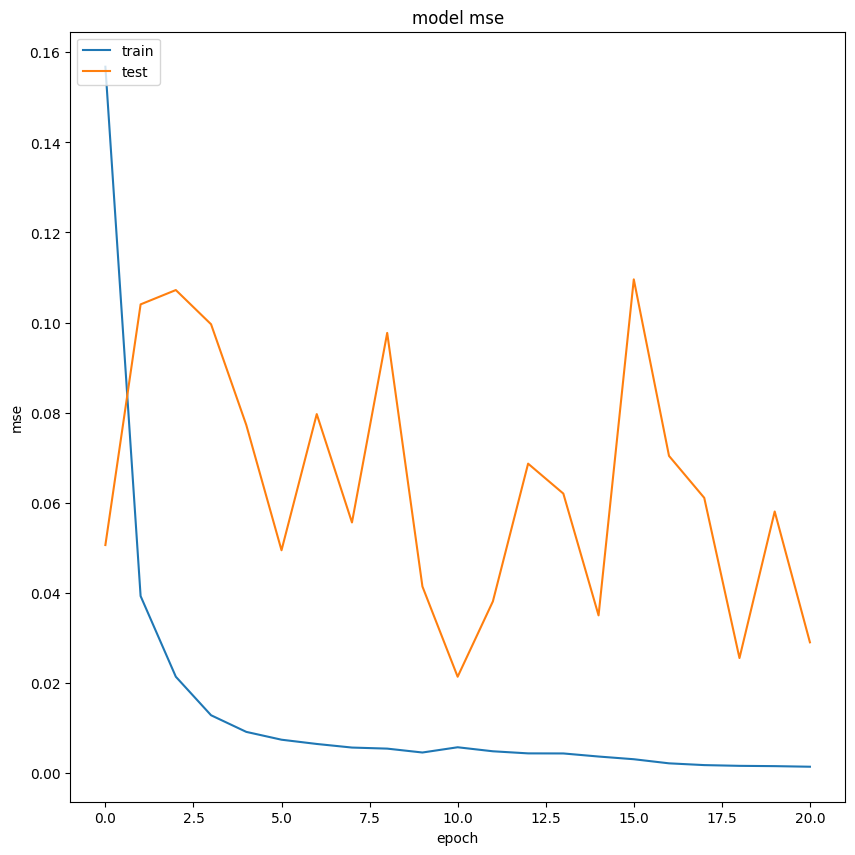

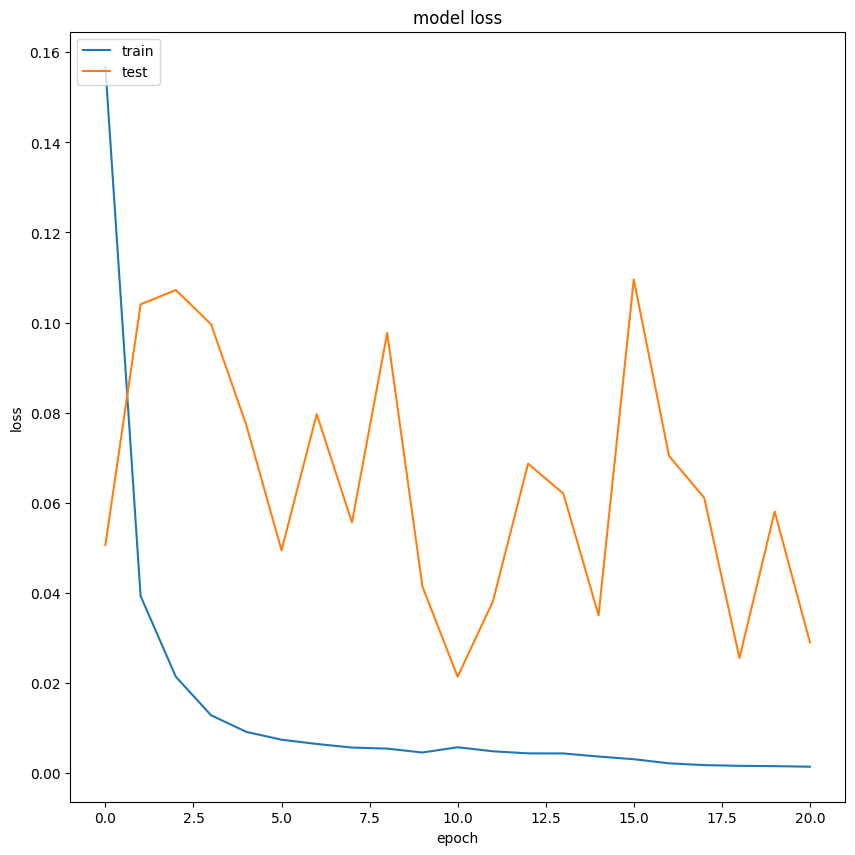

stacked_lstm_model_selected


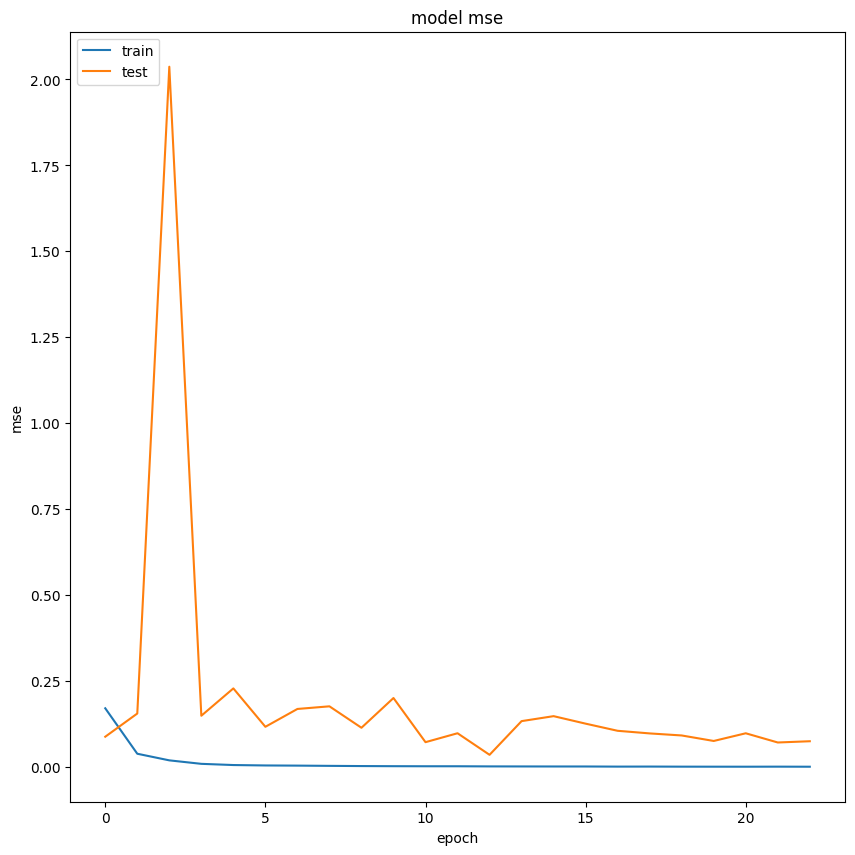

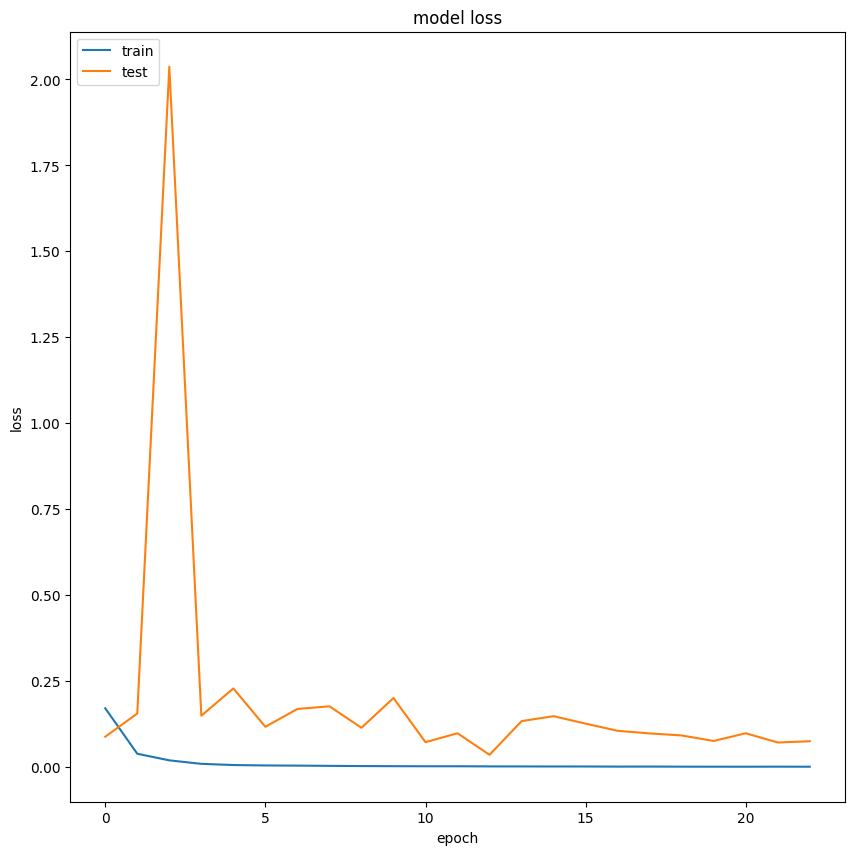

bidirectional_lstm_model_selected


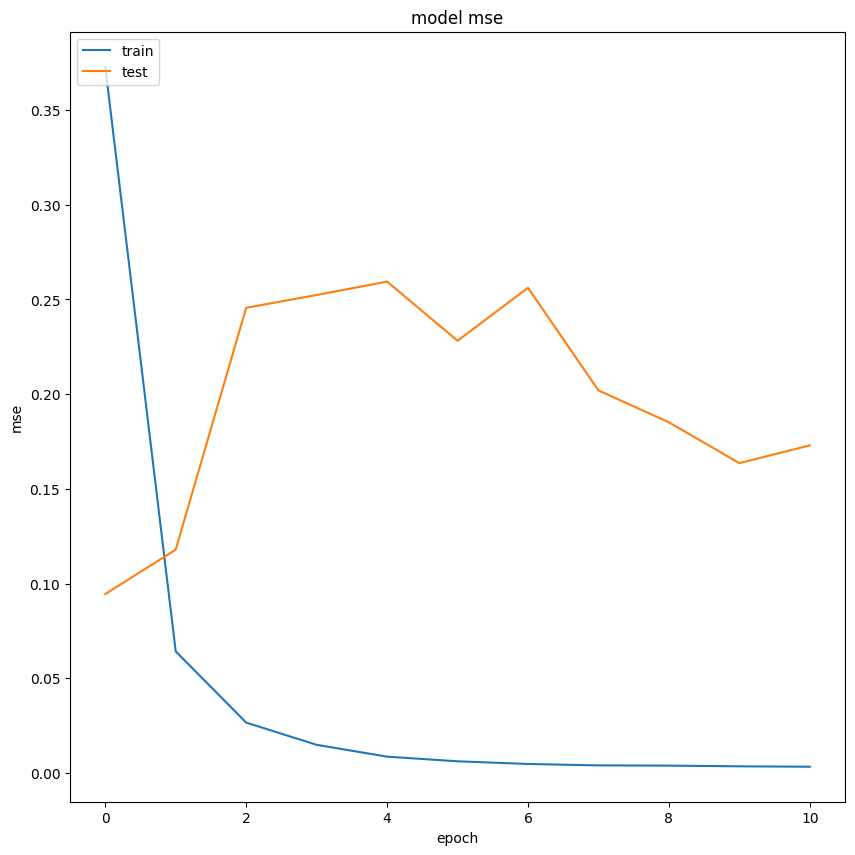

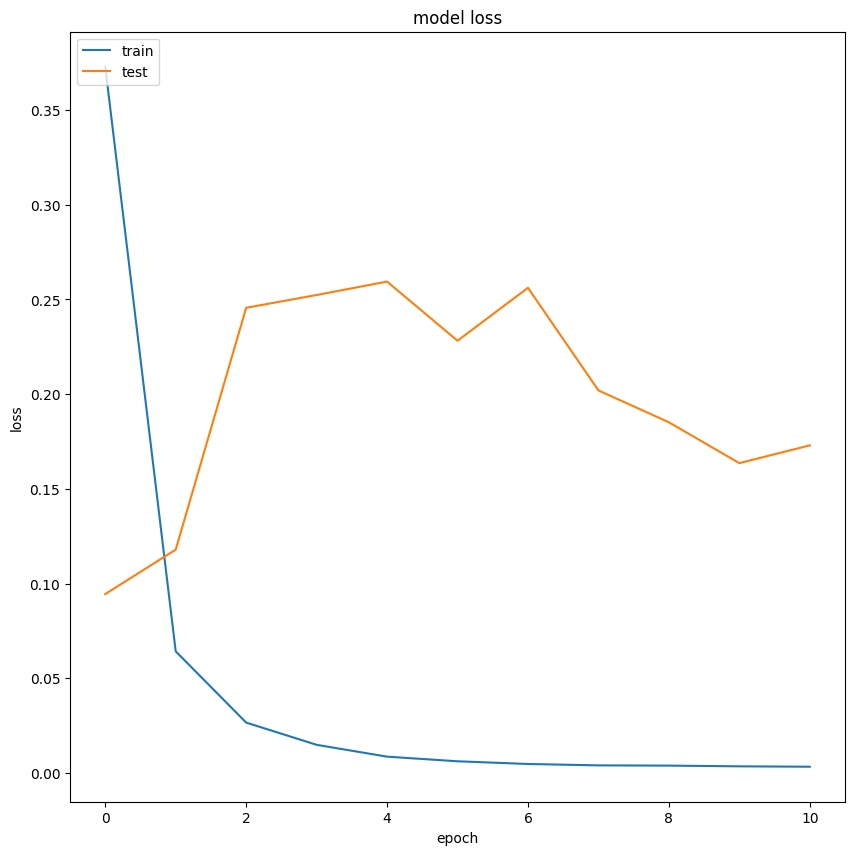

In [49]:
for k in histories_selected:
    print(f"{k}")
    view_history_mse_loss(histories_selected[k], k + '.png')

### Create Helping Metrics Functions

In [52]:
# load models from file
def load_all_models(models):
    all_models = {}
    for k in models:
        # define filename for this ensemble
        filename = k + '.h5'
        # load model from file
        model = load_model(filename)
        # add to list of members
        all_models[k] = model
        print('>loaded %s' % filename)
    return all_models

def regression_report(model, y_true, y_pred):
    report = {}
    
    # Model Name
    report['model'] = model
    
    # Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_true, y_pred)
    report['MAE'] = mae

    # Mean Squared Error (MSE)
    mse = mean_squared_error(y_true, y_pred)
    report['MSE'] = mse

    # Root Mean Squared Error (RMSE)
    rmse = mse ** 0.5
    report['RMSE'] = rmse

    # R-squared (R²) Score
    r_squared = r2_score(y_true, y_pred)
    report['R-squared'] = r_squared

    return report

def evaluate_model(name, report, score):
    for k in report:
        score[k].append(report[k])

    print(f"Model: {name}")
    print(f"MAE: {score['MAE'][-1]:.2f}")
    print(f"MSE: {score['MSE'][-1]:.2f}")
    print(f"RMSE: {score['RMSE'][-1]:.2f}")
    print(f"R-squared: {score['R-squared'][-1]:.2f}")
    print("------------------------------------------")
    
def display_score(data):
    # Create a DataFrame from the input dictionary
    df = pd.DataFrame(data)
    
    # Apply some styles
    styled_df = df.style.set_properties(**{'text-align': 'center'}) \
                        .set_table_styles([{'selector': 'th', 'props': [('background-color', 'lightblue')]}])
    
    # Format numerical values to two decimal places
    styled_df = styled_df.format('{:.2f}', subset=pd.IndexSlice[:, ['MAE', 'MSE', 'RMSE', 'R-squared']])
    
    # Add a caption and hide the index
    styled_df = styled_df.set_caption("Regression Evaluation Metrics")
    
    return styled_df

def display_tables_side_by_side(t1, title1, t2, title2):
    title1 = f'<h2 align="center">{title1}</h2>'
    title2 = f'<h2 align="center">{title2}</h2>'
    
    # Add captions to each table
    t1 = t1.set_caption(title1)
    t2 = t2.set_caption(title2)

    # Get the HTML representations of the Styler objects
    html1 = t1._repr_html_()
    html2 = t2._repr_html_()

    # Combine the HTML tables side by side with some space in between
    html = f'<div style="display: flex;">{html1}<div style="width: 20px;"></div>{html2}</div>'

    # Display the combined tables
    display(HTML(html))
    
def plot_predictions(model, X, y, start=-500):
    predictions = model.predict(X).flatten()
    df = pd.DataFrame(data={'Predictions': predictions, 'Actuals':y})
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(df['Predictions'][start:])
    plt.plot(df['Actuals'][start:])
    plt.legend(['Predictions', 'Actuals'], loc='upper left')
    plt.show()

### Load Models

In [53]:
members_set = {"vanilla_lstm_model", "stacked_lstm_model", "bidirectional_lstm_model"}
members = load_all_models(members_set)
print('Loaded %d models' % len(members_set))

members_set_selected = {"vanilla_lstm_model_selected", "stacked_lstm_model_selected", 
                        "bidirectional_lstm_model_selected"}
members_selected = load_all_models(members_set_selected)
print('Loaded %d models' % len(members_set_selected))

>loaded vanilla_lstm_model.h5
>loaded bidirectional_lstm_model.h5
>loaded stacked_lstm_model.h5
Loaded 3 models
>loaded vanilla_lstm_model_selected.h5
>loaded bidirectional_lstm_model_selected.h5
>loaded stacked_lstm_model_selected.h5
Loaded 3 models


### Evaluate Models without Feature Selection

In [54]:
score = {"model":[],"MAE":[],"MSE":[],"RMSE":[],"R-squared":[]}
for model in members:
    y_pred = members[model].predict(X_val, verbose=0)
    report = regression_report(model, y_val, y_pred)
    evaluate_model(model, report, score)

Model: vanilla_lstm_model
MAE: 0.31
MSE: 0.43
RMSE: 0.65
R-squared: -9.74
------------------------------------------
Model: bidirectional_lstm_model
MAE: 0.39
MSE: 0.16
RMSE: 0.40
R-squared: -3.12
------------------------------------------
Model: stacked_lstm_model
MAE: 0.23
MSE: 0.06
RMSE: 0.25
R-squared: -0.54
------------------------------------------


### Evaluate Models with Feature Selection

In [55]:
score_selected = {"model":[],"MAE":[],"MSE":[],"RMSE":[],"R-squared":[]}
for model in members_selected:
    y_pred = members_selected[model].predict(X_selected_val, verbose=0)
    report = regression_report(model, y_val, y_pred)
    evaluate_model(model, report, score_selected)

Model: vanilla_lstm_model_selected
MAE: 0.16
MSE: 0.03
RMSE: 0.17
R-squared: 0.27
------------------------------------------
Model: bidirectional_lstm_model_selected
MAE: 0.41
MSE: 0.17
RMSE: 0.42
R-squared: -3.36
------------------------------------------
Model: stacked_lstm_model_selected
MAE: 0.26
MSE: 0.08
RMSE: 0.27
R-squared: -0.90
------------------------------------------


### View Models Predictions without Feature Selection

vanilla_lstm_model prediction:
78/78 [==============================] - 0s 5ms/step


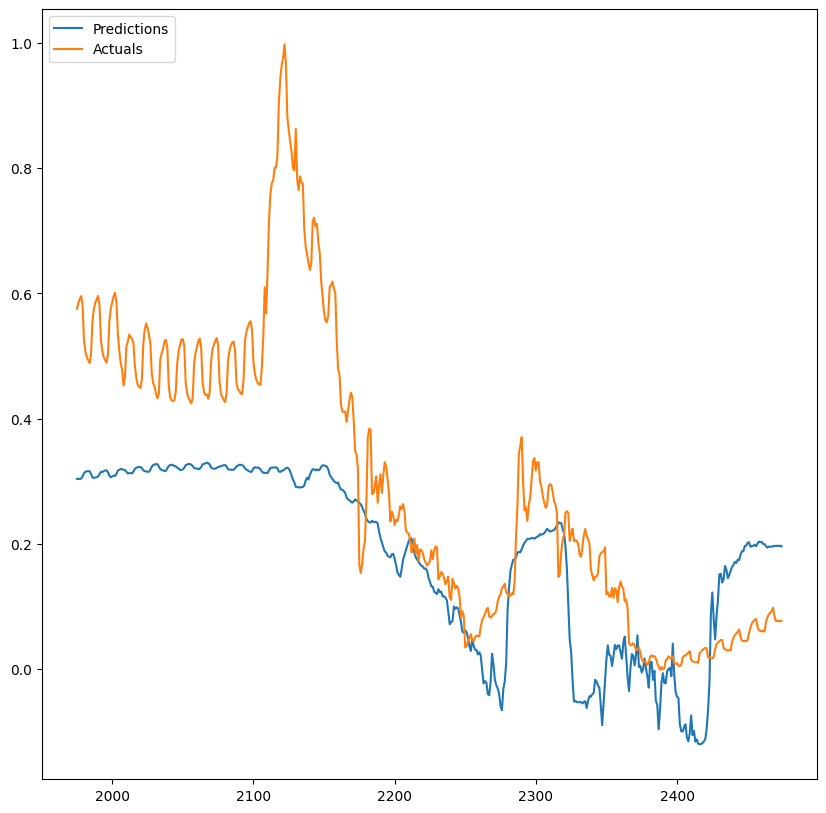

bidirectional_lstm_model prediction:
78/78 [==============================] - 1s 10ms/step


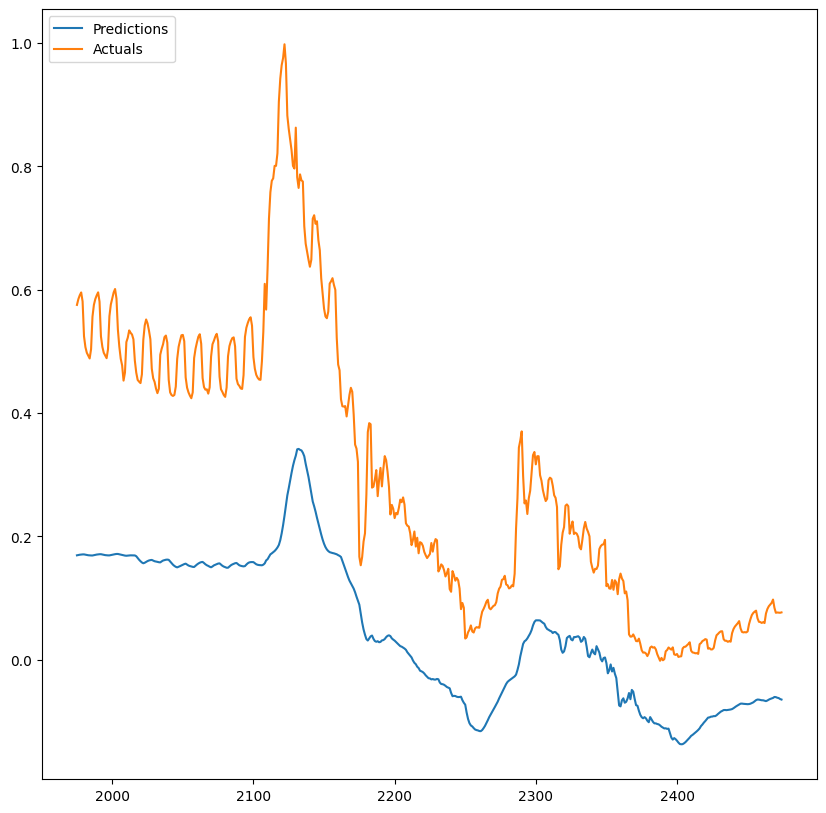

stacked_lstm_model prediction:
78/78 [==============================] - 0s 4ms/step


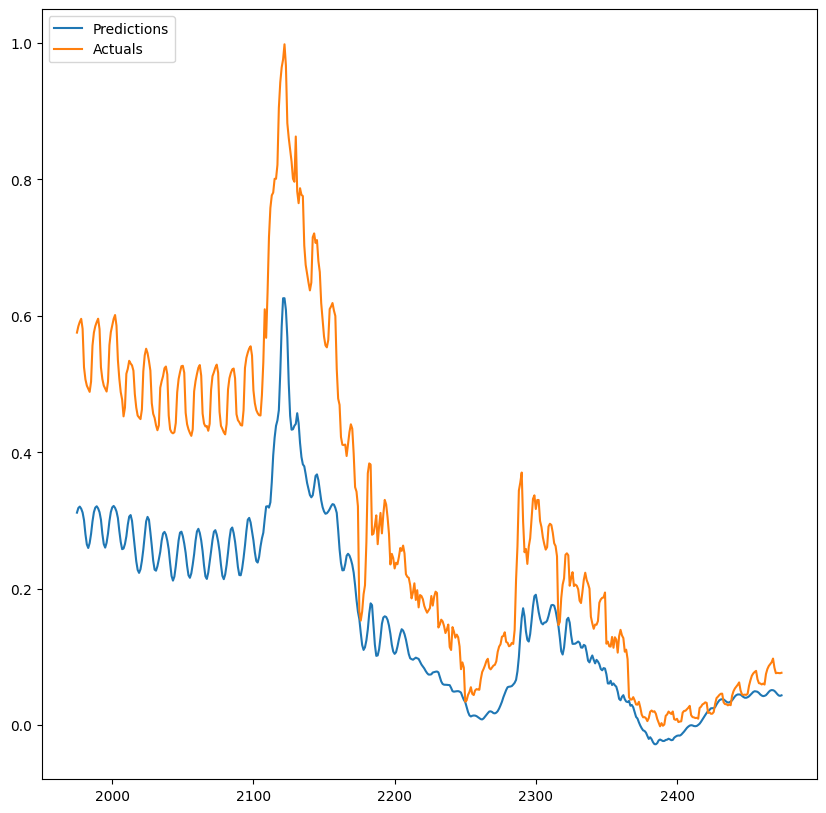

In [56]:
for model in members:
    print(f"{model} prediction:")
    plot_predictions(members[model], X_val, y_val)

### View Models Predictions with Feature Selection

vanilla_lstm_model_selected prediction:
78/78 [==============================] - 0s 5ms/step


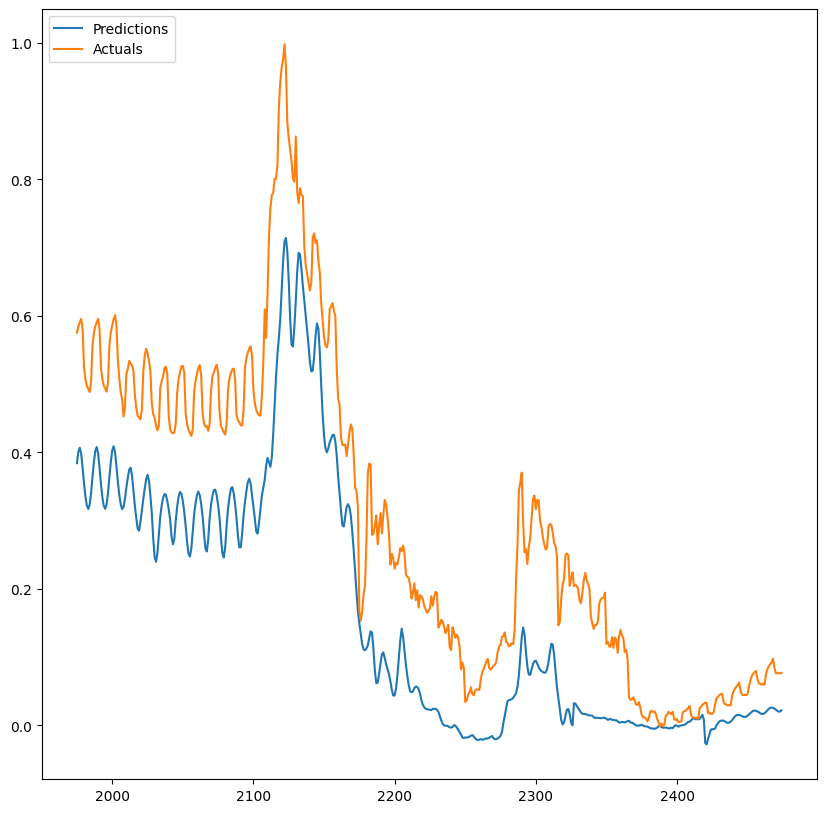

bidirectional_lstm_model_selected prediction:
78/78 [==============================] - 1s 10ms/step


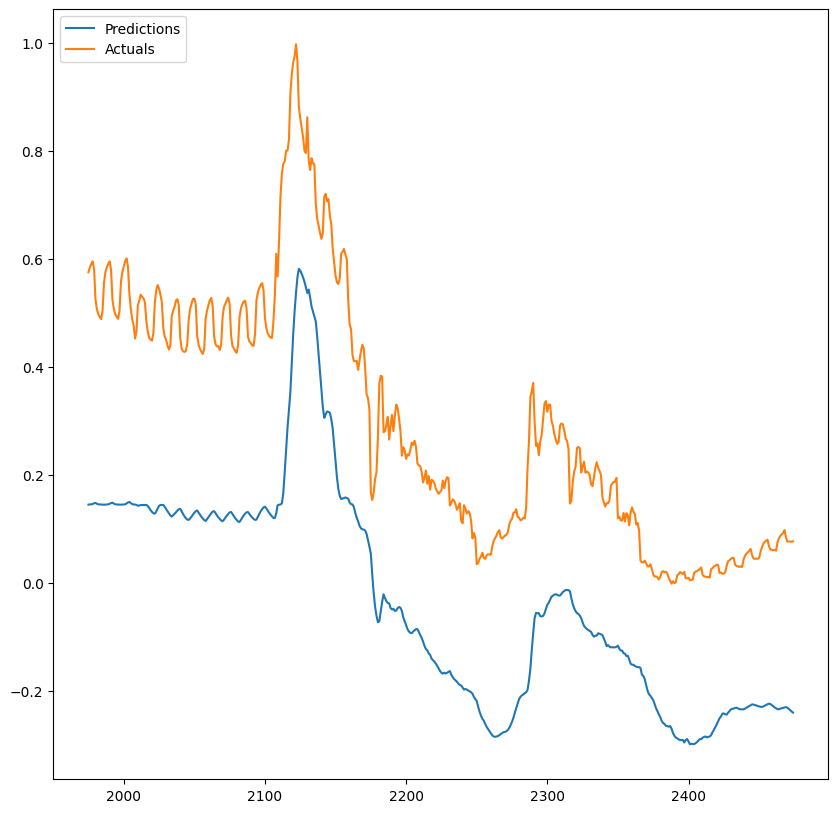

stacked_lstm_model_selected prediction:
78/78 [==============================] - 0s 4ms/step


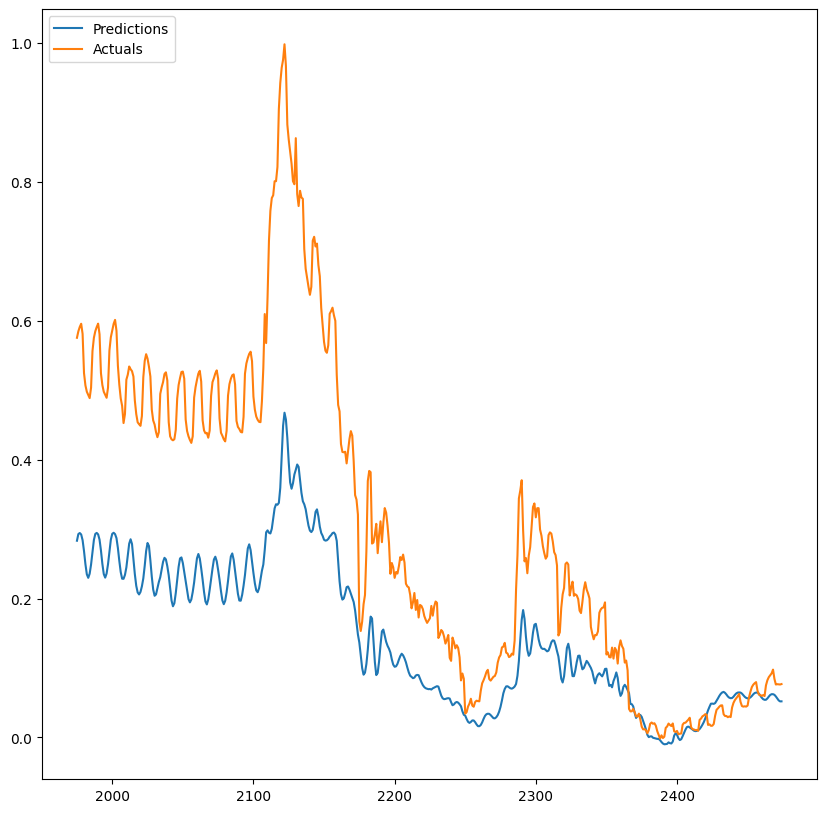

In [57]:
for model in members_selected:
    print(f"{model} prediction:")
    plot_predictions(members_selected[model], X_selected_val, y_val)

In [58]:
t1 = display_score(score)
t2 = display_score(score_selected)
display_tables_side_by_side(t1, "Without Feature Selection", t2, "With Feature Selection")

,model,MAE,MSE,RMSE,R-squared
0,vanilla_lstm_model,0.31,0.43,0.65,-9.74
1,bidirectional_lstm_model,0.39,0.16,0.40,-3.12
2,stacked_lstm_model,0.23,0.06,0.25,-0.54
,model,MAE,MSE,RMSE,R-squared
0,vanilla_lstm_model_selected,0.16,0.03,0.17,0.27
1,bidirectional_lstm_model_selected,0.41,0.17,0.42,-3.36
2,stacked_lstm_model_selected,0.26,0.08,0.27,-0.90


## Conclusion
The evaluation of humidity prediction models using time-series data and deep learning techniques revealed intriguing insights into the significance of feature selection on model performance. Initially, the vanilla LSTM, bidirectional LSTM, and stacked LSTM models demonstrated varying performance degrees without feature selection. While the vanilla LSTM and bidirectional LSTM models exhibited moderate accuracy metrics, including MAE and RMSE, the stacked LSTM model outperformed them with lower error metrics. However, all models struggled with a negative R-squared value, indicating poor fit to the data and potential overfitting issues.

Following feature selection, notable improvements in model performance were observed, particularly for the vanilla LSTM model. By focusing on relevant features, this model substantially reduced MAE and RMSE, accompanied by a positive R-squared value, signifying a better alignment with the underlying data patterns. Interestingly, the bidirectional LSTM and stacked LSTM models experienced mixed outcomes with feature selection, highlighting the nuanced impact of feature engineering on different model architectures. While the bidirectional LSTM model's performance degraded slightly, the stacked LSTM model maintained comparable performance, albeit with minor fluctuations in accuracy metrics.

Overall, these findings underscore the critical role of feature selection in enhancing the accuracy and generalization of deep learning models for humidity prediction tasks. By identifying and incorporating only the most informative features, models can mitigate overfitting tendencies and improve their ability to capture underlying data dynamics accurately. Further research could explore advanced feature selection techniques and investigate the synergistic effects of combining multiple feature subsets. Additionally, ensemble learning methods could offer avenues for achieving even higher predictive accuracy and robustness in environmental monitoring systems and related applications.